# TP : Message Passing, GCN et GAT
Ce TP vous propose de manipuler les concepts de message passing, GCN et GAT sur des graphes simples.

## 1. Construction d'un graphe
Créez un graphe représentant un réseau social ou moléculaire. Chaque nœud aura une caractéristique (ex : âge, type d'atome).

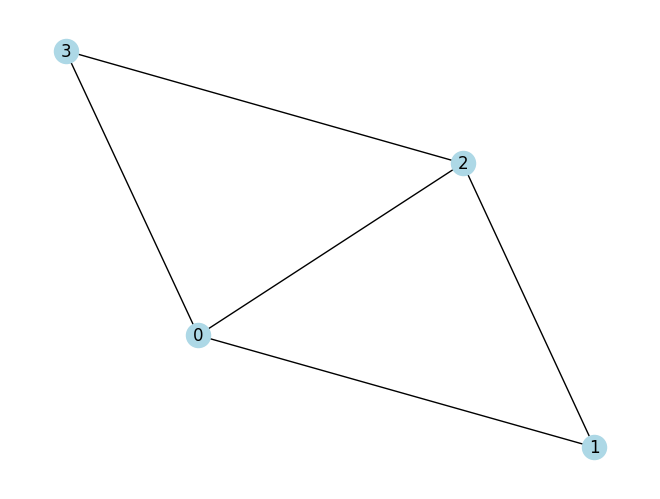

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_nodes_from([(0, {'age': 25}), (1, {'age': 30}), (2, {'age': 22}), (3, {'age': 28})])
G.add_edges_from([(0,1), (1,2), (2,3), (3,0), (0,2)])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue')
plt.show()

## 2. Algorithme de message passing
Implémentez une étape de message passing où chaque nœud met à jour sa caractéristique en fonction de ses voisins.

In [2]:
def message_passing(G):
    new_ages = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        neighbor_ages = [G.nodes[n]['age'] for n in neighbors]
        new_ages[node] = 0.5 * G.nodes[node]['age'] + 0.5 * (sum(neighbor_ages)/len(neighbor_ages))
    for node in G.nodes():
        G.nodes[node]['age'] = new_ages[node]
message_passing(G)
print([G.nodes[n]['age'] for n in G.nodes()])

[25.833333333333336, 26.75, 24.833333333333336, 25.75]


## 3. GCN avec PyTorch Geometric
Utilisez PyTorch Geometric pour appliquer un GCN sur le graphe.

In [6]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
x = torch.tensor([[25.],[30.],[22.],[28.]], dtype=torch.float)
edge_index = torch.tensor([[0,1,1,2,2,3,3,0,0,2],[1,0,2,1,3,2,0,3,2,0]], dtype=torch.long)
data = Data(x=x, edge_index=edge_index)
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 4)
        self.conv2 = GCNConv(4, 2)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x
model = GCN()
out = model(data.x, data.edge_index)
print(out)

/home/ymesri/miniconda3/envs/tr-tp/lib/python3.14/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._show_config()
/home/ymesri/miniconda3/envs/tr-tp/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[-7.8502, 16.8499],
        [-6.8982, 14.8064],
        [-7.8502, 16.8499],
        [-6.8351, 14.6711]], grad_fn=<AddBackward0>)


## 4. GAT avec PyTorch Geometric
Appliquez un GAT et comparez les résultats avec le GCN.

In [7]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(1, 4, heads=2)
        self.conv2 = GATConv(8, 2, heads=1)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x
gat_model = GAT()
gat_out = gat_model(data.x, data.edge_index)
print(gat_out)

tensor([[-2.6252, 13.6749],
        [-2.6280, 13.6898],
        [-2.6252, 13.6749],
        [-2.6330, 13.7157]], grad_fn=<AddBackward0>)


## 5. Questions de réflexion
- Quelle différence observez-vous entre les résultats du GCN et du GAT ?
- Dans quels cas l'attention (GAT) apporte-t-elle un avantage ?
- Comment adapteriez-vous ces modèles à des graphes plus grands ou hétérogènes ?

## Corrigé — réponses aux questions de réflexion

**Question 1 — Quelle différence observez-vous entre les résultats du GCN et du GAT ?**

- Le GCN applique une agrégation normalisée fixe (par multiplication par D^{-1/2} A D^{-1/2}) : tous les voisins contribuent selon une normalisation déterministe. Le résultat est une moyenne (linéaire) pondérée par la structure du graphe mais non adaptée à la tâche.
- Le GAT apprend des coefficients d'attention \(\alpha_{ij}\) pour chaque arête : il peut favoriser certains voisins et atténuer d'autres lors de l'agrégation. En pratique, cela produit des représentations où l'information venant des voisins « pertinents » pèse plus.
- Numériquement, les sorties peuvent être proches ou différentes selon la tâche et le graphe : sur des graphes où tous les voisins sont informatifs, les différences seront faibles ; si certains voisins sont bruyants/irrélevants, le GAT peut donner de meilleurs résultats.

**Question 2 — Dans quels cas l'attention (GAT) apporte-t-elle un avantage ?**

- Graphes hétérogènes ou bruyants : quand la qualité des voisins varie (ex. réseaux sociaux avec amis peu pertinents), l'attention permet de filtrer.
- Relations multi-typiques : si certaines arêtes sont plus informatives que d'autres, l'attention apprend à pondérer.
- Tâches nécessitant une sélection fine d'information locale (ex. classification de nœuds avec signaux locaux faibles).

Coûts et limites : l'attention augmente la complexité (plus de paramètres, calcul des coefficients), et peut sur-ajuster sur petits jeux si on ne régularise pas.

**Question 3 — Comment adapteriez-vous ces modèles à des graphes plus grands ou hétérogènes ?**

- Échantillonnage / mini-batching : utiliser GraphSAGE (neighbor sampling), PyG `NeighborSampler` ou méthodes comme `GraphSAINT` pour former sur des sous-graphes.
- Traitement sparse et opérations en mémoire limitée : profiter des opérateurs sparses optimisés et d'algorithmes mini-batch.
- Hétérogénéité : utiliser des modèles relationnels (RGCN) ou GNNs pour graphes hétérogènes (HeteroConv, relational layers) et encoder types de nœuds/arêtes.
- Scalabilité : distillation, pré-calcul de features, pooling hiérarchique (DiffPool), ou entraînement distribué.
- Robustesse : normalisation (BatchNorm/LayerNorm), dropedge, régularisation, et résidus/skip-connections pour éviter l'oversmoothing.

Conseil pratique : commencez par un modèle léger (GCN/GraphSAGE), profilez le coût mémoire/temps, puis essayez GAT/relational uniquement si la structure le justifie.


In [8]:
# Comparaison numérique des sorties GCN vs GAT
import numpy as np

# Si les tenseurs existent (exécutés précédemment), affichez-les et leur différence
try:
    gcn_out = out.detach().cpu().numpy()
    gat_out = gat_out.detach().cpu().numpy()
    print("GCN output:\n", gcn_out)
    print("GAT output:\n", gat_out)
    print("L2 diff:", np.linalg.norm(gcn_out - gat_out))
except NameError as e:
    print("Les variables `out` ou `gat_out` ne sont pas définies. Executez d'abord les cellules GCN et GAT.")


GCN output:
 [[-7.8501883 16.849863 ]
 [-6.8981743 14.806433 ]
 [-7.8501883 16.849863 ]
 [-6.8351073 14.671066 ]]
GAT output:
 [[-2.625153  13.674931 ]
 [-2.628011  13.689816 ]
 [-2.625153  13.674931 ]
 [-2.6329732 13.715668 ]]
L2 diff: 10.621404
